![The 18th ACM Recommender Systems Conference RecSys 2024 
Bari, Italy October 14 – 18, 2024.
](imgs/header.png)

# <font face="gotham" color="Brown"> Text based VA_RecSys with Latent Dirichlet Allocation (LDA) </font>




## Table of Contents

1. [Improt Deependencies](#dep)
2. [Load dataset](#loaddata)
3. [Preprocessing](#preproc)
4. [Latent Dirichlet Allocation (LDA) Model training](#model)<br>
5. [Comparative analysis of text sourses](#comp)
6. [Visualization](#viz)
7. [Top-K Recommendation](#topn)
8. [Explaining Recommendations with topic distributions](#exp)
9. [Conclusion 🏁](#con)

# <font face="gotham" color="darkred"> The HC RecSys Pipeline  </font>

![The RecSys pipline](imgs/recsys.png)

## 1. Improt Deependencies 

<a id="dep"></a>

In [1]:
#!conda install -c anaconda gensim

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy
import sys
import seaborn as sns
import random
from wordcloud import WordCloud
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from keras.preprocessing import image
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis
from PIL import Image
import requests
pd.options.display.max_colwidth = 50
import os, re, operator, warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib
%matplotlib widget
%matplotlib inline
# Bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

Loading BokehJS ...

## 2. Load dataset

<a id="loaddata"></a>
The dataset used in this tutorial contains >= 2,300 paintings collections from the National Gallery, London, dating from the mid-13th century to 1900.

![Sample painting](imgs/sample.png)

In [71]:
df = pd.read_csv('resources/datasets/ng-dataset.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.rename(columns={'merged_description': 'enhanced'}, inplace=True)
df['keywords'] = df['title'] + ' ' + df['artist'] + ' ' +  df['date'] + ' ' + df['room'] + ' ' + df['size_format'] + ' ' + df['size_class'] + ' ' + df['technique']

In [72]:
df.head()

painting_id                              title                    artist  \
0  000-00A8-0000          A Cup of Water and a Rose  Francisco de ZurbarÃÂ¡n   
1  000-00S0-0000                    Man on a Ladder           Luca Signorelli   
2  000-0162-0000  The Boulevard Montmartre at Night          Camille Pissarro   
3  000-0163-0000  View of the Westerkerk, Amsterdam        Jan van der Heyden   
4  000-0164-0000             The Museum at Le Havre              Claude Monet   

           date           room size_format  size_class  \
0  17th_century  006-002N-0000   Landscape  Very Small   
1  16th_century  006-0002-0000    Portrait      Medium   
2  19th_century  006-000L-0000   Landscape       Small   
3  17th_century  006-000B-0000   Landscape      Medium   
4  19th_century  006-000T-0000   Landscape      Medium   

                                         description     technique  \
0  <p>Although ZurbarÃÂ¡n frequently included st...  oil painting   
1  <p>Signorelli is celebrated for his mastery of...  oil painting   
2  <p>Towards the end of his life Pissarro increa...  oil painting   
3  <p>This painting is unusually large. It was co...  oil painting   
4  <p>This is an important work which dates from ...  oil painting   

                                               image  \
0  https://media.ng-london.org.uk/iiif/009-00YS-0...   
1  https://media.ng-london.org.uk/iiif/009-00UA-0...   
2  https://media.ng-london.org.uk/iiif/009-018T-0...   
3  https://media.ng-london.org.uk/iiif/009-01OT-0...   
4  https://media.ng-london.org.uk/iiif/009-01WV-0...   

                                            enhanced  \
0  <p>Although ZurbarÃÂ¡n frequently included st...   
1  <p>Signorelli is celebrated for his mastery of...   
2  <p>Towards the end of his life Pissarro increa...   
3  <p>This painting is unusually large. It was co...   
4  <p>This is an important work which dates from ...   

                                            keywords  
0  A Cup of Water and a Rose Francisco de ZurbarÃ...  
1  Man on a Ladder Luca Signorelli 16th_century 0...  
2  The Boulevard Montmartre at Night Camille Piss...  
3  View of the Westerkerk, Amsterdam Jan van der ...  
4  The Museum at Le Havre Claude Monet 19th_centu...

## 3. Preprocessing


<a id="preproc"></a>

"Garbage in, garbage out". 
We need to preprocess the textual descriptions of the paintings so that irrelevant information is removed.

To do that we proceed with the following steps :
- Removing the stopwords (a, the, of, with, ... ) + ( context words : painting, show, ... )
- Removing punctuation
- Removing numbers
- Lemmatization (am, is, are => be )
- Bigram (New York, 19th century, ...)

In [73]:
def replace_break(text):
    text = text.replace("\n", "")
    text = text.replace("<p>", "")
    text = text.replace("</p>", "")
    text = text.replace("<br>", "")
    text = text.replace("<br />", "")
    text = text.replace("< p >", "")
    text = text.replace("</p >", "")
    return text


df['description'] = df['description'].apply(replace_break)
df['enhanced'] = df['enhanced'].apply(replace_break)
df['keywords'] = df['keywords'].apply(replace_break)

In [74]:
pd.set_option("display.max_colwidth", 1000)
ng_text = df['description'].to_string(index=False)
merge_text = df['enhanced'].to_string(index=False)
keywords_text = df['keywords'].to_string(index=False)


In [75]:
ng_text = re.sub(' +', ' ', ng_text).replace('<br>', '')
ng_text = ng_text.replace('\n ', ' \n')
merge_text = re.sub(' +', ' ', merge_text).replace('<br>', '')
merge_text = merge_text.replace('\n ', ' \n')
keywords_text = re.sub(' +', ' ', keywords_text).replace('<br>', '')
keywords_text = keywords_text.replace('\n ', ' \n')

In [76]:
def add_stopwords(text, nlp):
    # Removing additional stopwords related to our context
    my_stop_words = ["'s", 'be', 'work', 'small', 'know', 'appear', 'early', 'de', 'earlier', 'depict', 'tell', 'type', 'apparently', 'paint', 'show', 'probably', 'picture', 'left', 'right', 'date', 'suggest', 'hold', 'see', 'represent']
    for stopword in my_stop_words:
        nlp.vocab[stopword].is_stop = True
    doc = nlp(text)
    return doc

def clean_text(doc, nlp):
    # we add some words to the stop word list
    texts, article, skl_texts = [], [], []
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if w.text != '\n' and not w.is_stop and not nlp.vocab[w.lemma_].is_stop and not w.is_punct and not w.like_num:
            # we add the lematized version of the word
            article.append(w.lemma_)
        # if it's a new line, it means we're onto our next document
        if w.text == '\n':
            skl_texts.append(' '.join(article))
            texts.append(article)
            article = []
    for li in texts:
        if ' ' in li:
            li.remove(' ')
    return texts

    
# We wrap all the preprocessing in one function for future reusability
def preprocess(text):
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 10000000
    doc = add_stopwords(text, nlp)
    texts = clean_text(doc, nlp)
    bigram = gensim.models.Phrases(texts)
    texts = [bigram[line] for line in texts]
    
    # Create a corpus from a list of texts
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=10, no_above=0.2)
    corpus = [dictionary.doc2bow(text) for text in texts]
    return texts, dictionary, corpus

<a id="comp"></a>
Two text sources:
- ng_texts --> Descriptions
- merge_texts --> Descriptions + Title + Artist + Date + Size Format + Size Class + Technique

In [77]:
#Incase you encouter issues in python 3.9 try installing en_core_web_sm-3.0.0
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

`en_core_web_sm` is an English language multi-task Convolutional Neural Network(CNN) trained on OntoNotes. Assigns context-specific token vectors, POS tags, dependency parse, and named entities. For more details on other available models such as `en_core_web_md`,`en_core_web_lg`, `en_core_web_trf` check out the spaCy models page here [here](https://spacy.io/models/en#en_core_web_sm). 

In [78]:
ng_texts, ng_dict, ng_corpus = preprocess(ng_text)

In [79]:
merge_texts, merge_dict, merge_corpus = preprocess(merge_text)

In [80]:
keywords_texts, keywords_dict, keywords_corpus = preprocess(keywords_text)

In [85]:
ng_corpus[0][5:10] #(index, frequency)

[(5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]

In [86]:
ng_texts[0][5:10]

['subject', 'independent', 'life', 'motif', 'cup']

In [83]:
ng_texts[3]

['painting',
 'unusually',
 'large_commission',
 'governor',
 'Westerkerk',
 'meeting',
 'room',
 'remain',
 'signature',
 'low',
 'step',
 'house',
 'unclear',
 'originally',
 'read',
 'church',
 'comparatively',
 'recent',
 'building',
 'time',
 'begin',
 'design',
 'hendrick',
 'Keyser',
 'complete',
 'east',
 'Keizersgracht',
 '\\rcharacteristic',
 'van_der',
 'Heyden',
 'specialise',
 'town',
 'view',
 'way',
 'minute',
 'detail',
 'figure',
 'add',
 'later',
 'interestingly',
 'artist',
 'attention',
 'detail',
 'shadow',
 'reflection',
 'water',
 'miss']

In [84]:
train = {}
train['ng'] = [ng_texts, ng_dict, ng_corpus]
train['merge'] = [merge_texts, merge_dict, merge_corpus]
#train['keywords'] = [keywords_texts, keywords_dict, keywords_corpus]

## 4. LDA Model training

Latent Dirichlet Allocation (LDA) is arguably the most famous topic modelling algorithm out there.

<a id="model"></a>
Two datasets :
- Description
- Description + Title + Artist + Date + Size Format + Size Class + Technique

In this part we want to identify which dataset is the best for our topic modeling. Moreover, we want to find the optimal number of topics. For that, we refer to a metrics called topic coherence that is commonly used for assessing topics quality.

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=123)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
results = {}
for key in train.keys():
    model_list, coherence_values = compute_coherence_values(dictionary=train[key][1], corpus=train[key][2], texts=train[key][0], start=2, limit=50, step=2)
    results[key] = [model_list, coherence_values]

## 5. Comparative analysis of text sourses

<a id="comp"></a>




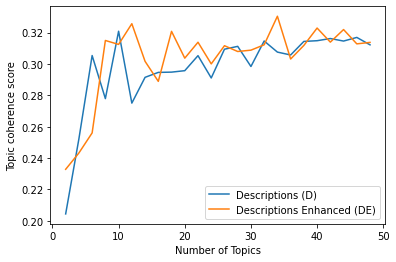

In [19]:
# Show graph
limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, results['ng'][1], x, results['merge'][1])
plt.xlabel("Number of Topics")
plt.ylabel("Topic coherence score")
plt.gca().legend(('Descriptions (D)','Descriptions Enhanced (DE)'))
plt.show()

In [19]:
results = {}
for key in train.keys():
    model_list, coherence_values = compute_coherence_values(dictionary=train[key][1], corpus=train[key][2], texts=train[key][0], start=2, limit=200, step=1)
    results[key] = [model_list, coherence_values]

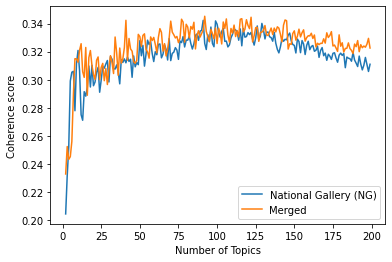

In [20]:
# Show graph
limit=200; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, results['ng'][1], x, results['merge'][1])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.gca().legend(('National Gallery (NG)','Merged'))
plt.show()

We can see that globally, National Gallery description dataset (blue curve) have a coherence score that is globally lower than the dataset that results from merging Description + Artist Name, Publishing Date, ...
Besides, it seems that there is a notable change of slope at around 10 topics.

Therefore, for the next part of the analysis, we will set the __number of topics to 11 and work with the merged dataset__

In [21]:
for key in train.keys():
    lda_model = gensim.models.ldamodel.LdaModel(corpus=train[key][2], num_topics=10, id2word=train[key][1], random_state=123)

    # Compute Coherence Score
    coherence_model = CoherenceModel(model=lda_model, 
                                               texts=train[key][0], 
                                               dictionary=train[key][1], 
                                               coherence='c_v')

    coherence_lda = coherence_model.get_coherence()
    print('\nCoherence Score', key,': ', coherence_lda)


Coherence Score ng :  0.32085147592260116

Coherence Score merge :  0.31245644334982564


In [22]:
for key in train.keys():
    lda_model = gensim.models.ldamodel.LdaModel(corpus=train[key][2], num_topics=11, id2word=train[key][1], random_state=123)

    # Compute Coherence Score
    coherence_model = CoherenceModel(model=lda_model, 
                                               texts=train[key][0], 
                                               dictionary=train[key][1], 
                                               coherence='c_v')

    coherence_lda = coherence_model.get_coherence()
    print('\nCoherence Score', key,': ', coherence_lda)


Coherence Score ng :  0.30629347548817715

Coherence Score merge :  0.3210099900739787


In [23]:
for key in train.keys():
    lda_model = gensim.models.ldamodel.LdaModel(corpus=train[key][2], num_topics=12, id2word=train[key][1], random_state=123)

    # Compute Coherence Score
    coherence_model = CoherenceModel(model=lda_model, 
                                               texts=train[key][0], 
                                               dictionary=train[key][1], 
                                               coherence='c_v')

    coherence_lda = coherence_model.get_coherence()
    print('\nCoherence Score', key,': ', coherence_lda)


Coherence Score ng :  0.275018154004123

Coherence Score merge :  0.3256510197876521


In [24]:
for key in train.keys():
    lda_model = gensim.models.ldamodel.LdaModel(corpus=train[key][2], num_topics=13, id2word=train[key][1], random_state=123)

    # Compute Coherence Score
    coherence_model = CoherenceModel(model=lda_model, 
                                               texts=train[key][0], 
                                               dictionary=train[key][1], 
                                               coherence='c_v')

    coherence_lda = coherence_model.get_coherence()
    print('\nCoherence Score', key,': ', coherence_lda)


Coherence Score ng :  0.27109827661123626

Coherence Score merge :  0.3057394180554762


### LDA with 11 topics and the merge descriptions dataset 

In [20]:
merge_corpus = train['merge'][2]
merge_dict = train['merge'][1]
lda_model = gensim.models.ldamodel.LdaModel(corpus=merge_corpus, num_topics=11, id2word=merge_dict, random_state=123)
# Return the matrix of topic per document
topic_doc_matrix = lda_model[merge_corpus]

# Reordering the topics in ascending order (0,1,2,3...) so we can compare them using a similarity metrics
sorted_topic_doc_matrix = [
    sorted(doc_topics, key=lambda x: x[0])
    for doc_topics in topic_doc_matrix
]
num_topics = 11
for doc_topics in sorted_topic_doc_matrix:
    present_topic_ids = set(topic[0] for topic in doc_topics)
    missing_topic_ids = set(range(num_topics)) - present_topic_ids
    doc_topics.extend([(topic_id, 0) for topic_id in missing_topic_ids])
    doc_topics.sort(key=lambda x: x[0])


In [21]:
topic_doc_matrix[200]

[(0, 0.29146472), (2, 0.43265295), (3, 0.054320335), (5, 0.206034)]

In [22]:
sorted_topic_doc_matrix[200]

[(0, 0.29143265),
 (1, 0),
 (2, 0.4326543),
 (3, 0.054322913),
 (4, 0),
 (5, 0.20606212),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0)]

In [23]:
np.save('Models/topic-doc',sorted_topic_doc_matrix)

![LDA similarity](imgs/sim.png)

In [24]:
# Convert the sorted_topic_doc_matrix into a numpy matrix
topic_doc_matrix_array = [list(map(lambda x: x[1], doc_topics)) for doc_topics in sorted_topic_doc_matrix]
topic_doc_matrix_array = np.array(topic_doc_matrix_array)

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(topic_doc_matrix_array)

In [25]:
similarity_matrix

array([[1.        , 0.72344062, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.72344062, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.77171755, 0.20668529,
        0.        ],
       ...,
       [0.        , 0.        , 0.77171755, ..., 1.        , 0.04495058,
        0.07718654],
       [0.        , 0.        , 0.20668529, ..., 0.04495058, 1.        ,
        0.76047756],
       [0.        , 0.        , 0.        , ..., 0.07718654, 0.76047756,
        1.        ]])

In [26]:
#Save similarity matrix
np.save('models/cosine_matrix', similarity_matrix)

## 6. Visualization
<a id="viz"></a>

In [27]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, merge_corpus, merge_dict)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.025657  0.013384       1        1  14.564043
7     -0.163475 -0.024173       2        1  13.322892
3     -0.093330 -0.004653       3        1  10.520645
4      0.025043  0.023011       4        1   9.292687
8      0.044415 -0.083160       5        1   9.112082
1     -0.089560  0.040952       6        1   8.997236
5      0.045878  0.033844       7        1   8.949437
6      0.077439 -0.012704       8        1   7.104880
9      0.032354 -0.102898       9        1   6.701100
10    -0.005855  0.065158      10        1   6.283992
2      0.101432  0.051239      11        1   5.151007, topic_info=              Term        Freq       Total Category  logprob  loglift
143       portrait  632.000000  632.000000  Default  30.0000  30.0000
32          Christ  446.000000  446.000000  Default  29.0000  29.0000
358         Virgin  320.000000  320.000000  Default  28.0000  28.0000
568   Virgin_Child  353.000000  353.000000  Default  27.0000  27.0000
211         sketch  148.000000  148.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
996          think   16.152507  161.110432  Topic11  -5.3014   0.6660
13         include   16.206601  179.416003  Topic11  -5.2980   0.5617
1    Landscape_oil   15.017706  151.779705  Topic11  -5.3742   0.6528
87           later   15.142819  178.214166  Topic11  -5.3659   0.5005
64           scene   15.426726  293.206984  Topic11  -5.3473   0.0212

[771 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
1711      2  0.842240  000a-0000_Portrait
1711      3  0.046791  000a-0000_Portrait
1711      4  0.046791  000a-0000_Portrait
1711      9  0.046791  000a-0000_Portrait
1859      3  0.076308  001a-0000_Portrait
...     ...       ...                 ...
1527      5  0.210715               ÃÂ_ 
1804      4  0.652739              Ã¢ÂÂ
1804      7  0.124331              Ã¢ÂÂ
1804     10  0.186497              Ã¢ÂÂ
1804     11  0.031083              Ã¢ÂÂ

[3793 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 4, 5, 9, 2, 6, 7, 10, 11, 3])

### 10 Topics

In [28]:
merge_corpus = train['merge'][2]
merge_dict = train['merge'][1]
lda_model = gensim.models.ldamodel.LdaModel(corpus=merge_corpus, num_topics=10, id2word=merge_dict, random_state=123)
# Return the matrix of topic per document
topic_doc_matrix = lda_model[merge_corpus]

# Reordering the topics in ascending order (0,1,2,3...) so we can compare them using a similarity metrics
sorted_topic_doc_matrix = [
    sorted(doc_topics, key=lambda x: x[0])
    for doc_topics in topic_doc_matrix
]
num_topics = 11
for doc_topics in sorted_topic_doc_matrix:
    present_topic_ids = set(topic[0] for topic in doc_topics)
    missing_topic_ids = set(range(num_topics)) - present_topic_ids
    doc_topics.extend([(topic_id, 0) for topic_id in missing_topic_ids])
    doc_topics.sort(key=lambda x: x[0])

In [29]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, merge_corpus, merge_dict)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.020457  0.004181       1        1  14.356633
3     -0.088447  0.004370       2        1  11.467317
7     -0.127373  0.019521       3        1  11.348000
1     -0.098191  0.005810       4        1  10.773058
4      0.028627 -0.010902       5        1  10.347317
5      0.048723  0.014378       6        1   9.703753
8      0.011097 -0.068084       7        1   9.690454
6      0.089136 -0.092883       8        1   8.553773
9      0.007888  0.013532       9        1   7.203083
2      0.108083  0.110079      10        1   6.556612, topic_info=             Term        Freq       Total Category  logprob  loglift
143      portrait  619.000000  619.000000  Default  30.0000  30.0000
358        Virgin  326.000000  326.000000  Default  29.0000  29.0000
568  Virgin_Child  360.000000  360.000000  Default  28.0000  28.0000
11         flower  120.000000  120.000000  Default  27.0000  27.0000
32         Christ  458.000000  458.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
38         figure   24.802803  516.412389  Topic10  -5.1138  -0.3113
256       century   22.413887  447.470245  Topic10  -5.2150  -0.2692
87          later   19.665087  176.717563  Topic10  -5.3459   0.5290
17           life   19.008276  223.045068  Topic10  -5.3798   0.2622
33     Medium_oil   18.550594  409.235389  Topic10  -5.4042  -0.3691

[686 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
1711      3  0.782186  000a-0000_Portrait
1711      4  0.048887  000a-0000_Portrait
1711      5  0.048887  000a-0000_Portrait
1711      9  0.048887  000a-0000_Portrait
1859      2  0.079917  001a-0000_Portrait
...     ...       ...                 ...
1804      5  0.490259              Ã¢ÂÂ
1804      6  0.122565              Ã¢ÂÂ
1804      7  0.030641              Ã¢ÂÂ
1804      8  0.153206              Ã¢ÂÂ
1804     10  0.122565              Ã¢ÂÂ

[3261 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 8, 2, 5, 6, 9, 7, 10, 3])

#####  t-SNE visualization of paintings based on their principal topic ( topic with highest distribution )

In [30]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=merge_corpus, num_topics=11, id2word=merge_dict, random_state=123)
topic_doc_matrix = lda_model[merge_corpus]
hm = np.zeros((len(merge_corpus), 11))  # Initialize an array with zeros

for i, doc_topics in enumerate(topic_doc_matrix):
    for topic_id, topic_prob in doc_topics:
        hm[i, topic_id] = topic_prob

tsne = TSNE(random_state=2017, perplexity=500, early_exaggeration=120)
embedding = tsne.fit_transform(hm)
embedding = pd.DataFrame(embedding, columns=['x', 'y'])
embedding['hue'] = hm.argmax(axis=1)


In [115]:
source = ColumnDataSource(
        data=dict(
            x = embedding.x,
            y = embedding.y,
            artist = df.artist,
            title = df.title,
            colors = [all_palettes['Set3'][11][w] for i, w in enumerate(embedding.hue)],
            alpha = [0.9] * embedding.shape[0],
            size = [7] * embedding.shape[0]
        )
    )
hover_tsne = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Artist:</span>
            <span style="font-size: 12px">@artist</span>
            <br>
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
        </div>
    </div>
    """)
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset', 'save']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='t-SNE visualization of documents')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', 
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

callback = CustomJS(args=dict(source=source), code=
    """
    var data = source.data;
    var f = cb_obj.value
    x = data['x']
    y = data['y']
    colors = data['colors']
    alpha = data['alpha']
    artist = data['artist']
    title = data['title']
    size = data['size']
    for (i = 0; i < x.length; i++) {
        if (year[i] <= f) {
            alpha[i] = 0.9
            size[i] = 7
        } else {
            alpha[i] = 0.05
            size[i] = 4
        }
    }
    source.change.emit();
    """)


show(plot_tsne)

In [32]:
lda_model.print_topics()

[(0,
  '0.026*"portrait" + 0.013*"figure" + 0.012*"artist" + 0.010*"Medium_oil" + 0.010*"sitter" + 0.008*"woman" + 0.008*"man" + 0.008*"painter" + 0.007*"century" + 0.007*"16th_century_Portrait"'),
 (1,
  '0.020*"Christ" + 0.013*"Virgin" + 0.011*"Virgin_Child" + 0.008*"angel" + 0.007*"altarpiece" + 0.006*"figure" + 0.006*"background" + 0.006*"art" + 0.006*"Corot" + 0.005*"16th_century_Landscape"'),
 (2,
  '0.011*"portrait" + 0.010*"flower" + 0.009*"figure" + 0.008*"blue" + 0.008*"©" + 0.007*"Isabella" + 0.007*"child" + 0.007*"artist" + 0.007*"18th_century_Portrait" + 0.006*"Medium_oil"'),
 (3,
  '0.017*"Christ" + 0.012*"Virgin" + 0.012*"panel" + 0.012*"century" + 0.011*"Virgin_Child" + 0.010*"16th_century_Portrait" + 0.009*"altarpiece" + 0.007*"Saint" + 0.007*"Medium_oil" + 0.007*"scene"'),
 (4,
  '0.014*"artist" + 0.011*"century" + 0.010*"\xa0" + 0.009*"life" + 0.009*"portrait" + 0.009*"boy" + 0.008*"composition" + 0.008*"figure" + 0.007*"style" + 0.007*"man"'),
 (5,
  '0.012*"artist"

In [33]:
#Visualise words and thier probabilities in a topic
def topic2words(topic_id, topn):
    list_topics = lda_model.get_topic_terms(topic_id, topn)
    a = [(merge_dict[tup[0]], tup[1]) for tup in list_topics]
    return a
    

In [34]:
topic2words(7, 10)

[('Saint_John', 0.016329687),
 ('altarpiece', 0.014088636),
 ('Virgin_Child', 0.013039942),
 ('panel', 0.01295841),
 ('Saint', 0.012585774),
 ('Virgin', 0.012387988),
 ('15th_century_Portrait', 0.012375657),
 ('saint', 0.011594011),
 ('Christ', 0.010788372),
 ('Saints', 0.008898139)]

In [35]:
topic2words(6, 10)

[('artist', 0.013854844),
 ('figure', 0.009675044),
 ('portrait', 0.009383892),
 ('painter', 0.009339489),
 ('van', 0.008885484),
 ('woman', 0.00868289),
 ('dutch', 0.008135031),
 ('National_Gallery', 0.007683408),
 ('style', 0.0069767637),
 ('subject', 0.006694478)]

## 7. Top-K recommendation
<a id="topn"></a>
![LDA scoring](imgs/score.png)

In [36]:
class LDAEngine():
    def __init__(self):
        self.painting_df = pd.read_csv("resources/datasets/ng-dataset.csv")
        self.cos_mat = np.load("Models/cosine_matrix.npy")
        
    def unpack_prefs(self, preferences):
        painting_list = []
        weights = []
        for painting, rating in preferences.items():
            painting_list.append(painting)
            weights.append(rating)
        xmin = min(weights)
        xmax = max(weights)
        for i, x in enumerate(weights):
            weights[i] = (x - xmin) / (xmax - xmin + sys.float_info.epsilon)

        return painting_list, weights

    def index2pid(self, painting_df, index):
        """From the index, returns the painting ID from the paintings dataframe
        Input:
                painting_df: dataframe of paintings
                index: index of the painting in the dataframe
        Output:
                pid: return the painting ID (e.g: 000-02T4-0000 )
        """
        try:
            pid = painting_df.iloc[index].painting_id
        except IndexError as ie:
            pid = "Index '" + index + "' not found in dataset."
        return pid

    def indexlist2pidlist(self, painting_df, index_list):
        """From a list of indexes, returns the painting IDs
        Input:
                painting_df: dataframe of paintings
                index_list: list of the painting indexes in the dataframe
        Output:
                pid: list of paintings ID
        """
        pids_list = [self.index2pid(painting_df, index) for index in index_list]
        return pids_list

    def pid2index(self, painting_df, painting_id):
        """From the painting ID, returns the index of the painting in the painting dataframe
        Input:
                painting_df: dataframe of paintings
                painting_list: list of paintings ID (e.g ['000-02T4-0000', '000-03WC-0000...'])
        Output:
                index_list: list of the paintings indexes in the dataframe (e.g [32, 45, ...])
        """
        try:
            index = painting_df.loc[painting_df["painting_id"] == painting_id].index[0]
        except IndexError as ie:
            index = "Painting ID '" + painting_id + "' not found in dataset."
        return index

    def pidlist2indexlist(self, painting_df, painting_list):
        """From a list of painting ID, returns the indexes of the paintings
        Input:
                painting_df: dataframe of paintings
                painting_list: list of paintings ID (e.g ['000-02T4-0000', '000-03WC-0000...'])
        Output:
                index_list: list of the paintings indexes in the dataframe (e.g [32, 45, ...])
        """
        index_list = [
            self.pid2index(painting_df, painting_id) for painting_id in painting_list
        ]
        return index_list

    def retrieval(self, preferences, n=3):
        """Recommand paintings for a user based on a list of items that were liked
        Input:
                painting_list: list of paintings index liked by a user
                cos_mat: Cosine Similarity Matrix
                n: number of recommendation wanted
        Output:
                a list of indexes for recommended paintings
        """

        painting_list, weights = self.unpack_prefs(preferences)

        n_painting = len(painting_list)

        score_list = []
        index_list = self.pidlist2indexlist(self.painting_df, painting_list)

        weights = np.asarray(weights).reshape(-1, 1)
        for index in index_list:
            score = self.cos_mat[index]
            score[index] = 0
            score_list.append(score)

        score_list = np.sum(np.multiply(weights, score_list), axis=0) / n_painting
        top_n_index = sorted(
            range(len(score_list)), key=lambda i: score_list[i], reverse=True
        )[:n]

        top_n_pids = self.indexlist2pidlist(self.painting_df, top_n_index)

        return list(top_n_pids)

In [37]:

dir_path='resources/datasets/ng_images/'
def print_image(dir_path, selected_images_keys_list):
    fig = plt.figure()
    for i in range(len(selected_images_keys_list)):
        img_path = dir_path + selected_images_keys_list[i] + '.jpg'
        img = image.load_img(img_path, target_size=(224, 224))
        a = fig.add_subplot(1, len(selected_images_keys_list), i+1, autoscale_on=True)
        imgplot = plt.imshow(img)
        a.set_title(selected_images_keys_list[i])
        plt.axis('off')
        
def print_images(dir_path, selected_images_keys_list):
    fig, axes = plt.subplots(1, len(selected_images_keys_list), figsize=(15, 5))
    
    for i, image_key in enumerate(selected_images_keys_list):
        img_path = os.path.join(dir_path, f"{image_key}.jpg")
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(image_key)
        axes[i].axis('off')
    
    plt.tight_layout()
    #display(fig)


def doc_topics(index, sorted_topic_doc_matrix):
    sns.set(style="whitegrid")
    topics = range(len(sorted_topic_doc_matrix[index]))  # Assumes the number of topics is equal to the length of the topic distribution
    proportions = [topic[1] for topic in sorted_topic_doc_matrix[index]]
    
    fig, ax = plt.subplots()
    ax.bar(topics, proportions)
    
    ax.set_xlabel('Topics')
    ax.set_ylabel('Proportion')
    ax.set_title('Proportions of the topics for document index ' + str(index))
    ax.set_xticks(topics)
    
    plt.show()
    
    

    
def recommend_paintings(painting_df, painting_list, cos_mat, n):
    """Recommand paintings for a user based on a list of items that were liked
    Input: 
            painting_df: dataframe of paintings
            painting_list: list of paintings index liked by a user
            cos_sim_mat: Cosine Similarity Matrix
            n: number of recommendation wanted
    Output:
            a list of indexes for recommended paintings 
    """
    n_painting = len(painting_list)
    score_list = []
    index_list = eng.pidlist2indexlist(painting_df, painting_list)
    for index in index_list:
        score = cos_mat[index]
        score[index] = 0
        score_list.append(score)
    score_list = np.sum(score_list, 0)/n_painting 
    top_n_index = sorted(range(len(score_list)), key=lambda i: score_list[i], reverse=True)[:n]
    top_n_pids = eng.indexlist2pidlist(painting_df, top_n_index)
    return top_n_pids


### Simulate User preferences

In [38]:
preferences = {
        "000-02Q1-0000": 5,
        "000-04H4-0000": 5,
        "000-02W4-0000": 5,
        "000-02ND-0000": 5,
        "000-03N1-0000": 5,
        "000-019R-0000": 5,
        "000-03TQ-0000": 5,
        "000-019X-0000": 5,
        "000-02OU-0000": 5,
    }

### Retrieve top-K  Recommendations 

In [87]:
eng = LDAEngine()
Recommendations = eng.retrieval(preferences, n=9)

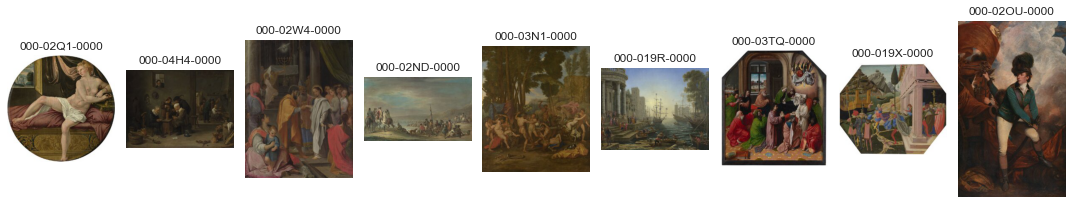

In [88]:
#plot user preferences
print_images(dir_path, preferences.keys())

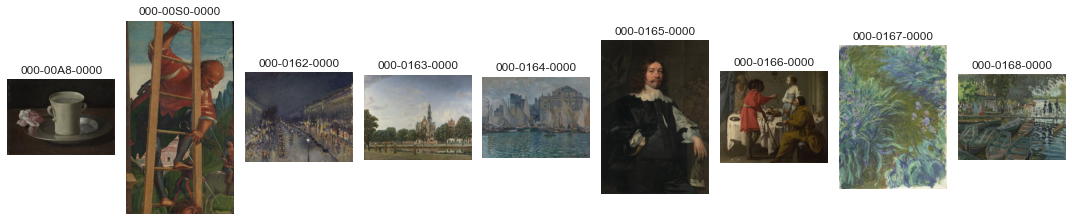

In [89]:
#plot Recommendations
print_images(dir_path, Recommendations)

## 8. Explananining Recommendations with Topic distributions
<a id="exp"></a>

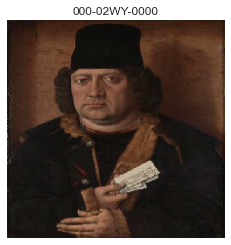

In [104]:
#Sample user preference
selected_images_keys_list = ['000-02WY-0000']
print_image(dir_path, selected_images_keys_list)

In [105]:
pid = selected_images_keys_list[0]
index = eng.pid2index(df, pid)

In [106]:
pid

'000-02WY-0000'

In [107]:
index

647

In [113]:
sorted_topic_doc_matrix[647]

[(0, 0.9608493),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0)]

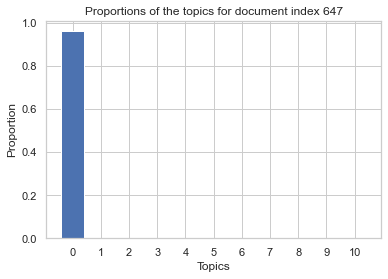

In [109]:
doc_topics(index, sorted_topic_doc_matrix)

In [110]:
#Get the most similar painting
painting_list = [pid]
topn = recommend_paintings(df, painting_list, similarity_matrix, 10)
topn[0]

#Get the index of the most similar recommendation
df.loc[df.painting_id == topn[0]]
index = eng.pid2index(df, topn[0])

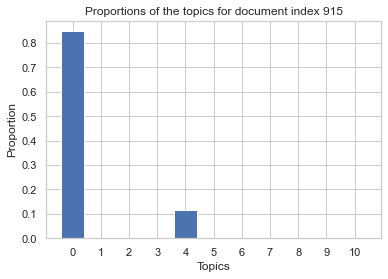

In [111]:
doc_topics(index, sorted_topic_doc_matrix)

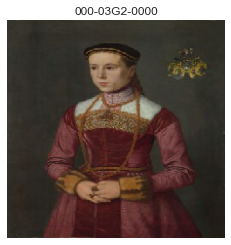

In [112]:
#display the most similar paintintg
selected_images_keys_list = [topn[0]]
print_image(dir_path, selected_images_keys_list)

In [114]:
topic2words(0, 10)

[('portrait', 0.026147204),
 ('figure', 0.012732625),
 ('artist', 0.011519536),
 ('Medium_oil', 0.010097533),
 ('sitter', 0.010052322),
 ('woman', 0.00807166),
 ('man', 0.008014283),
 ('painter', 0.007832827),
 ('century', 0.0071948343),
 ('16th_century_Portrait', 0.0071774805)]

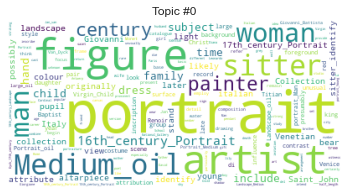

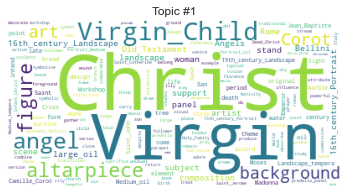

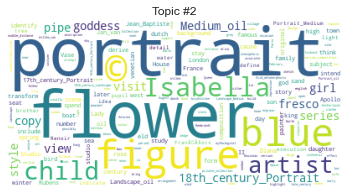

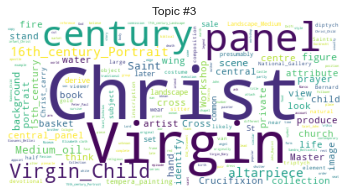

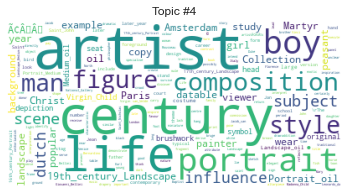

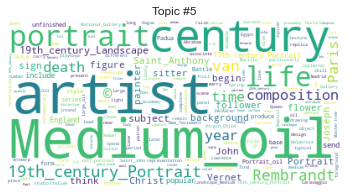

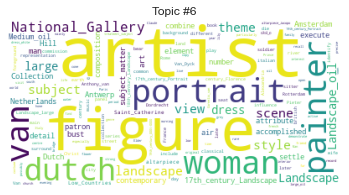

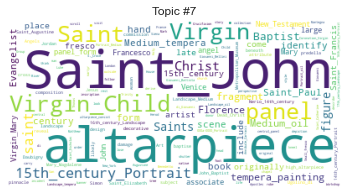

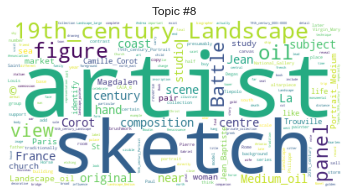

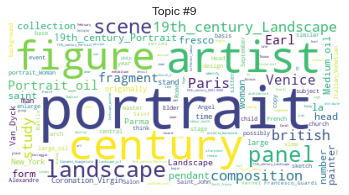

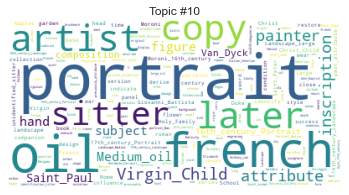

In [52]:
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='White').fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [53]:
df[df['painting_id'] == pid]

painting_id                           title  \
647  000-02WY-0000  Portrait of Alexander Mornauer   

                              artist          date           room size_format  \
647  Master of the Mornauer Portrait  15th_century  006-0025-0000    Portrait   

    size_class  \
647      Small   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            description  \
647  The sitter was town clerk of Landshut in Bavaria between 1464 and 1488. He is identified by the letter he holds, which is addressed to him. On his ring is the device of a moor's head, which may be a pun on the first syllable of his name. The background against which the sitter is shown is a wood grain, not uncommon in German portraits from the period.The original top edge of the painting has been cut slightly. The artist, who may have been Tyrolean, is named after this picture.   

        technique  \
647  oil painting   

                                                                         image  \
647  https://media.ng-london.org.uk/iiif/009-01D5-0000/full/256,/0/default.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     enhanced  \
647  The sitter was town clerk of Landshut in Bavaria between 1464 and 1488. He is identified by the letter he holds, which is addressed to him. On his ring is the device of a moor's head, which may be a pun on the first syllable of his name. The background against which the sitter is shown is a wood grain, not uncommon in German portraits from the period.The original top edge of the painting has been cut slightly. The artist, who may have been Tyrolean, is named after this picture. Portrait of Alexander Mornauer Master of the Mornauer Portrait 15th_century 006-0025-0000 Portrait Small oil painting   

                                                                                                                  keywords  
647  Portrait of Alexander Mornauer Master of the Mornauer Portrait 15th_century 006-0025-0000 Portrait Small oil painting

### 

In [54]:
df[df['painting_id'] == topn[0]]

painting_id                                    title  \
915  000-03G2-0000  Susanna Stefan, Wife of Wolfgang Furter   

                       artist          date           room size_format  \
915  Nicolas de NeufchÃÂ¢tel  16th_century  006-0002-0000    Portrait   

    size_class  \
915     Medium   

                                                                                                                                                                                                                                                                                                                                                                                     description  \
915  The young woman wears a richly embroidered, fur-trimmed dress typical of southern Germany. The coats of arms at the upper right corner, which were revealed when the painting was cleaned in 1968, identify the sitter as Susanna Stefan (died 1594), wife of Wolff Furter (1538? - 1594) of Nuremberg. Her glance suggests that a companion portrait of her husband may once have existed.   

        technique  \
915  oil painting   

                                                                         image  \
915  https://media.ng-london.org.uk/iiif/009-015F-0000/full/256,/0/default.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 enhanced  \
915  The young woman wears a richly embroidered, fur-trimmed dress typical of southern Germany. The coats of arms at the upper right corner, which were revealed when the painting was cleaned in 1968, identify the sitter as Susanna Stefan (died 1594), wife of Wolff Furter (1538? - 1594) of Nuremberg. Her glance suggests that a companion portrait of her husband may once have existed. Susanna Stefan, Wife of Wolfgang Furter Nicolas de NeufchÃÂ¢tel 16th_century 006-0002-0000 Portrait Medium oil painting   

                                                                                                                     keywords  
915  Susanna Stefan, Wife of Wolfgang Furter Nicolas de NeufchÃÂ¢tel 16th_century 006-0002-0000 Portrait Medium oil painting

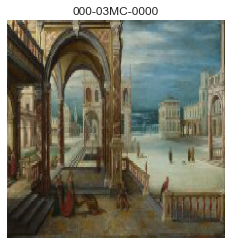

In [55]:
#Additional examples

selected_images_keys_list = ['000-03MC-0000']
print_image(dir_path, selected_images_keys_list)

In [56]:
pid = selected_images_keys_list[0]
index = eng.pid2index(df, pid)

In [57]:
pid

'000-03MC-0000'

In [58]:
index

1088

In [59]:
sorted_topic_doc_matrix[1088]

[(0, 0.3115007),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0.08864373),
 (6, 0),
 (7, 0),
 (8, 0.57291716),
 (9, 0),
 (10, 0)]

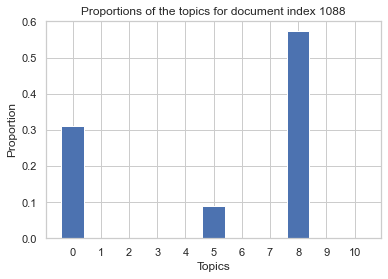

In [60]:
doc_topics(index, sorted_topic_doc_matrix)

In [61]:
#Get the most similar painting
painting_list = [pid]
topn = recommend_paintings(df, painting_list, similarity_matrix, 10)

#Get the index of the most similar recommendation
df.loc[df.painting_id == topn[0]]
index = eng.pid2index(df, topn[0])

In [62]:
topn[0]

'000-01D2-0000'

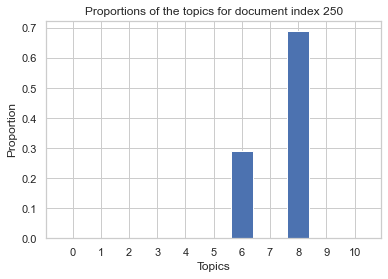

In [63]:
doc_topics(index, sorted_topic_doc_matrix)

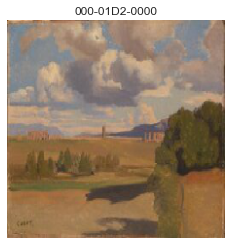

In [64]:
selected_images_keys_list = [topn[0]]
print_image(dir_path, selected_images_keys_list)

In [65]:
topic2words(8,10)

[('artist', 0.017104382),
 ('sketch', 0.014520852),
 ('19th_century_Landscape', 0.010711436),
 ('figure', 0.009689235),
 ('oil', 0.008611697),
 ('panel', 0.008173932),
 ('Battle', 0.007645905),
 ('view', 0.0071931435),
 ('composition', 0.006522212),
 ('La', 0.006134683)]

In [66]:
df[df['painting_id'] == pid]

painting_id  \
1088  000-03MC-0000   

                                                                     title  \
1088  A Man kneels before a Woman in the Courtyard of a Renaissance Palace   

                                  artist          date           room  \
1088  Hendrick van Steenwyck the Younger  17th_century  006-0002-0000   

     size_format size_class  \
1088   Landscape      Small   

                                                                                                                                                                                                                                                                                                                       description  \
1088  This painting presumably shows a scene from the Bible or classical history, but the subject has not been identified. Traditionally it was said to show Aeneas in the Palace of Dido. \rThe architecture, landscape and sky are certainly by Hendrick van Steenwyck the Younger but the figures are probably by another hand.   

         technique  \
1088  oil painting   

                                                                          image  \
1088  https://media.ng-london.org.uk/iiif/009-00LV-0000/full/256,/0/default.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          enhanced  \
1088  This painting presumably shows a scene from the Bible or classical history, but the subject has not been identified. Traditionally it was said to show Aeneas in the Palace of Dido. \rThe architecture, landscape and sky are certainly by Hendrick van Steenwyck the Younger but the figures are probably by another hand. A Man kneels before a Woman in the Courtyard of a Renaissance Palace Hendrick van Steenwyck the Younger 17th_century 006-0002-0000 Landscape Small oil painting   

                                                                                                                                                             keywords  
1088  A Man kneels before a Woman in the Courtyard of a Renaissance Palace Hendrick van Steenwyck the Younger 17th_century 006-0002-0000 Landscape Small oil painting

In [67]:
df[df['painting_id'] == topn[0]]

painting_id                                           title  \
250  000-01D2-0000  The Roman Campagna, with the Claudian Aqueduct   

                          artist          date           room size_format  \
250  Jean-Baptiste-Camille Corot  19th_century  006-000H-0000   Landscape   

     size_class  \
250  Very Small   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             description  \
250  The sketch is one of the open-air studies produced by Corot during his stay in Rome in 1825-8. It was bought by Degas in 1899 and acquired by the National Gallery at the Degas sale in 1918. Executed in oil on paper, the painting is noteworthy for the freedom and spontaneity of its handling, a forerunner of the open-air sketches that Corot was to produce in the years after his return to France, like the Seine near Rouen of about 1830-5.A morning scene, the painting shows the Alban Hills and the aqueduct of the Aqua Felice with a medieval tower in the centre. To the right and left are the arched ruins of the Aqua Claudia. The dense shadows contrast with the otherwise sunlit landscape.   

        technique  \
250  oil painting   

                                                                         image  \
250  https://media.ng-london.org.uk/iiif/009-009I-0000/full/256,/0/default.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        enhanced  \
250  The sketch is one of the open-air studies produced by Corot during his stay in Rome in 1825-8. It was bought by Degas in 1899 and acquired by the National Gallery at the Degas sale in 1918. Executed in oil on paper, the painting is noteworthy for the freedom and spontaneity of its handling, a forerunner of the open-air sketches that Corot was to produce in the years after his return to France, like the Seine near Rouen of about 1830-5.A morning scene, the painting shows the Alban Hills and the aqueduct of the Aqua Felice with a medieval tower in the centre. To the right and left are the arched ruins of the Aqua Claudia. The dense shadows contrast with the otherwise sunlit landscape. The Roman Campagna, with the Claudian Aqueduct Jean-Baptiste-Camille Corot 19th_century 006-000H-0000 Landscape Very Small oil painting   

                                                                                                                                    keywords  
250  The Roman Campagna, with the Claudian Aqueduct Jean-Baptiste-Camille Corot 19th_century 006-000H-0000 Landscape Very Small oil painting

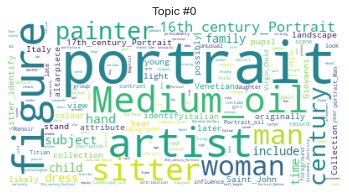

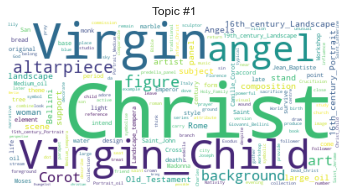

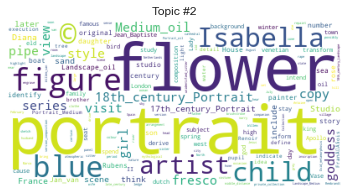

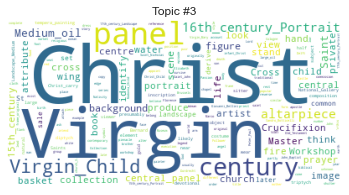

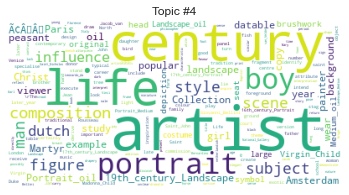

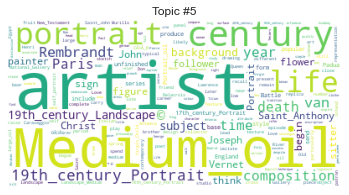

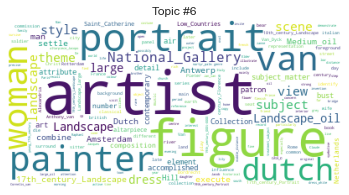

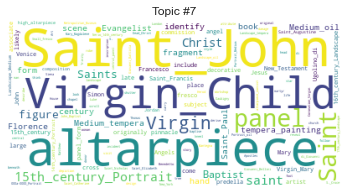

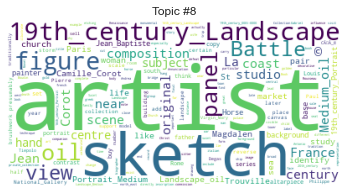

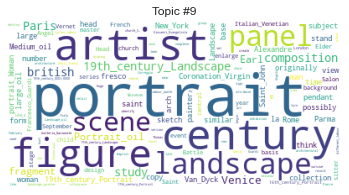

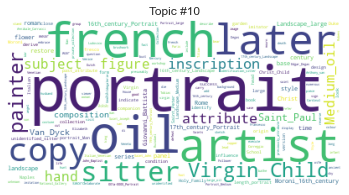

In [68]:
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='White').fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

## 🏁 9. Conclusion

<a id="con"></a>

Now, you know:

1. A popular topic modelling techinque, LDA
2. How to implement topic models using LDA via gensim library
3. How to apply topic models for a Recommendation task

The resourses used in this tutorial are partially taken from our [CHI2023 paper: The Elements of Visual Art Recommendation: Learning Latent Semantic Representations of Paintings](https://dl.acm.org/doi/abs/10.1145/3544548.3581477)

![VA_RecSys](imgs/VA_RecSys.png)



